<a href="https://colab.research.google.com/github/fariyanalam/Projects/blob/main/PHYS152_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Supersymmetric (SUSY) and Standard Model Particle Classification using Autoencoder + Classifier


**Introduction and Overview:**

The Large Hadron Collider (LHC) is a particle accelerator that allows for the collision of two high-energy particle beams which travel close to the speed of light. Since the introduction of the LHC, there have been significant advancements in particle physics,
including the discovery of the Higgs boson. The discovery of the Higgs boson proved the theoretical models beyond the Standard Model. Supersymmetric (SUSY) is considered as an extension of the Standard Model, predicting that every particle in the Standard Model has a partner particle with a different spin. Given the distinct spin values of
fermions and bosons, physicists can analyze collision data to identify differences in decay patterns and interaction properties.


**Data Loading & Exploration:**

First, we will import the dataset from Kaggle and visualize the data distributions after scaling. The purpose of this step is to get an idea of skewness, outliers, or abnormalities. We will choose a "random feature X" to check for normal distribution and skewness.

100%|██████████| 762M/762M [00:10<00:00, 76.5MB/s]

Extracting files...


   SUSY  lepton 1 pT  lepton 1 eta  lepton 1 phi  lepton 2 pT  lepton 2 eta  \
0   0.0     0.707258      0.613159     -0.763354     1.010814      1.672101   
1   0.0     0.493745     -1.745581     -0.640968     0.576161     -0.514477   
2   1.0     1.305413      0.283820     -1.149154     0.507217     -0.194161   
3   1.0     0.809715     -0.358303     -0.497172     0.787675      0.027419   
4   0.0     0.912852      1.797455     -1.360165     0.496723      1.199644   

   lepton 2 phi  missing energy magnitude  missing energy phi   MET_rel  \
0      1.544314                  0.342641            0.286944  0.514347   
1     -0.629788                  0.585841            0.874038  0.879419   
2      1.313993                  0.659832            0.619593  0.534922   
3      1.201305                  0.790556           -0.861923  0.740287   
4      0.627462                  1.206452           -1.362983  0.033791   

   axial MET       M_R    M_TR_2         R       MT2       S_R  M_Delta_R 

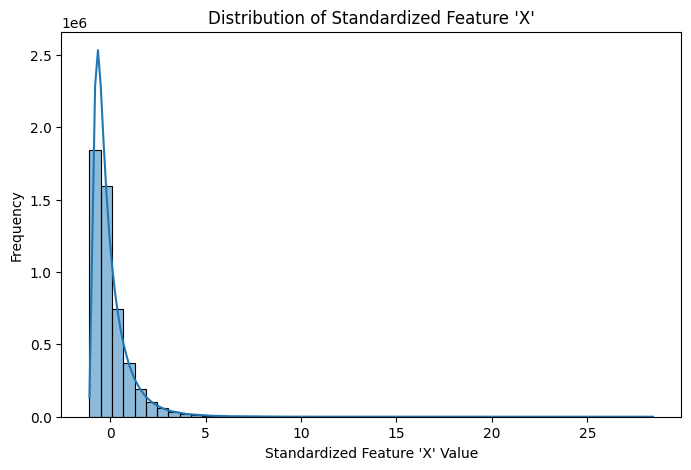

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import kagglehub

# Download and load the latest version of the dataset
path = kagglehub.dataset_download("janus137/supersymmetry-dataset")

dataset_path = "/root/.cache/kagglehub/datasets/janus137/supersymmetry-dataset/versions/1/supersymmetry_dataset.csv"
data = pd.read_csv(dataset_path, header=0)

print(data.head())

# Define the features and labels (0 = Standard Model, 1 = SUSY)
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

# Normalize features by scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Visualize a single feature distribution
plt.figure(figsize=(8, 5))
sns.histplot(X_scaled[:, 0], bins=50, kde=True)
plt.title("Distribution of Standardized Feature 'X'")
plt.xlabel("Standardized Feature 'X' Value")
plt.ylabel("Frequency")
plt.show()

**Autoencoder for Feature Extraction:**

Our next goal is to compress the features from the last step into a lower-dimension representation, which we'll feed into the binary classifier in the next step. The purpose of this step is to identify key patterns in the data and to reduce the noise (if any) in our dataset.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

#Defining the hyperparameters
input_dim = X_train.shape[1] #18 features
hidden_dim = 16
latent_dim = 8
learning_rate = 0.001
batch_size = 512
epochs = 15

#Definining the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

#Initalizing the model, loss function, and optimizer
autoencoder = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

#Dataloader
train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

#Training loop
for epoch in range(epochs):
    for batch in train_loader:
        inputs = batch[0]
        optimizer.zero_grad()
        outputs, encoded = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

torch.save(autoencoder.encoder.state_dict(), 'encoder.pth')

Epoch [1/15], Loss: 0.0945
Epoch [2/15], Loss: 0.1006
Epoch [3/15], Loss: 0.0918
Epoch [4/15], Loss: 0.0834
Epoch [5/15], Loss: 0.0672
Epoch [6/15], Loss: 0.0753
Epoch [7/15], Loss: 0.0712
Epoch [8/15], Loss: 0.0637
Epoch [9/15], Loss: 0.0590
Epoch [10/15], Loss: 0.0692
Epoch [11/15], Loss: 0.0717
Epoch [12/15], Loss: 0.0633
Epoch [13/15], Loss: 0.0723
Epoch [14/15], Loss: 0.0642
Epoch [15/15], Loss: 0.0579


**Binary Classifier:**

[Built classifier using compressed features]

**Conclusion:**

[Summarize findings and potential improvements]